<a href="https://colab.research.google.com/github/Pineappledeydre/fake_news_classification/blob/main/main_tweet_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The dataset is designed for detecting COVID-19-related fake news, specifically from social media platforms like Twitter, Facebook, and Instagram. It's part of the [CONSTRAINT-2021 shared task ](https://competitions.codalab.org/competitions/2665)on hostile post detection, which focuses on classifying social media posts as either fake or real news.

### Key details about the dataset:
- **Task**: Classifying social media posts (tweets) as real or fake news related to COVID-19.
- **Sources**: Data comes from social media platforms such as Twitter, Facebook, and Instagram.
- **Goal**: Given a social media post, the task is to determine whether it's real or fake news.

In [ ]:
!pip install --upgrade tensorflow-gpu==2.0
!pip install tweet-preprocessor

ERROR: Could not find a version that satisfies the requirement tensorflow-gpu==2.0 (from versions: 2.12.0)
ERROR: No matching distribution found for tensorflow-gpu==2.0


In [ ]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
!pip install plotly
!pip install --upgrade nbformat
!pip install nltk
!pip install spacy
!pip install WordCloud
!pip install gensim

import tensorflow as tf
import pandas as pd
import numpy as np
from collections import Counter
import random

from PIL import Image
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns


import torch
import torch.nn as nn
import preprocessor as p
from torch.utils.data import DataLoader, TensorDataset, Dataset
import torch.optim as optim
from torch.optim import Adam
from transformers import DistilBertTokenizer, DistilBertModel, BertModel, BertTokenizer, get_scheduler
from torch.cuda.amp import autocast, GradScaler
from torch.amp import autocast, GradScaler

import nltk
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download("stopwords")
from wordcloud import WordCloud, STOPWORDS
import re
import re
import requests
from urllib.parse import urlparse
import string
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import stopwords
from nltk import word_tokenize
from nltk.tokenize import word_tokenize, sent_tokenize
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS

from tensorflow.keras.preprocessing.text import one_hot, Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Embedding, Input, LSTM, Conv1D, MaxPool1D, Bidirectional, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
from sklearn.svm import SVC

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
sns.set(style="whitegrid", palette="Set2")

In [ ]:
colors = {
    'main_color': '#89ABE3',    # Primary color (blue)
    'secondary_color': '#EA738D',  # Secondary color (orange)
    'highlight_color': '#9494b8',  # Highlight color (light blue)
    'background_color': '#ffffff',  # Light gray background
    'text_color': '#000000',     # Main text color (dark gray)
    'axis_color': '#000000',     # Axis text and ticks color (gray)
    'title_color': '#000000',    # Title color (dark gray)
    'grid_color': '#000000',     # Gridline color (light gray)
}
custom_palette = [
    '#89ABE3', '#223A61', '#C3C9D4', '#A5495D' ,'#EA738D'
]
custom_palette_2 = [
    '#89ABE3','#EA738D'
]

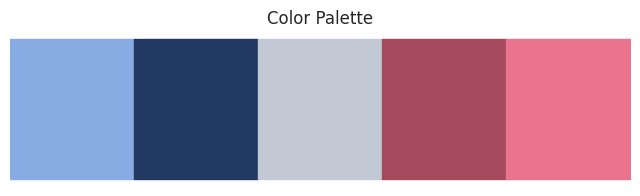

In [ ]:
plt.figure(figsize=(8, 2))
for i, color in enumerate(custom_palette):
    plt.fill_between([i, i + 1], 0, 1, color=color)
plt.xlim(0, len(custom_palette))
plt.axis("off")
plt.title("Color Palette")
plt.show()

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

# Preprocessing

## Load the Data

In [ ]:
url_train = "https://raw.githubusercontent.com/Pineappledeydre/fake_news_classification/main/data/Constraint_Train.csv"
url_val = "https://raw.githubusercontent.com/Pineappledeydre/fake_news_classification/main/data/Constraint_Val.csv"
url_test = "https://raw.githubusercontent.com/Pineappledeydre/fake_news_classification/main/data/Constraint_Test_Labeled.csv"


In [ ]:
Constraint_Train = pd.read_csv(url_train, index_col="id")
Constraint_Val = pd.read_csv(url_val, index_col="id")
Constraint_Test = pd.read_csv(url_test, index_col="id")

In [ ]:
# Display dataset information
Constraint_Val.head()

,tweet,label
id,,
1,Chinese converting to Islam after realising th...,fake
2,11 out of 13 people (from the Diamond Princess...,fake
3,"COVID-19 Is Caused By A Bacterium, Not Virus A...",fake
4,Mike Pence in RNC speech praises Donald Trump’...,fake
5,6/10 Sky's @EdConwaySky explains the latest #C...,real


In [ ]:
Constraint_Val.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2140 entries, 1 to 2140
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   tweet   2140 non-null   object
 1   label   2140 non-null   object
dtypes: object(2)
memory usage: 50.2+ KB


In [ ]:
Constraint_Train.head()

,tweet,label
id,,
1,The CDC currently reports 99031 deaths. In gen...,real
2,States reported 1121 deaths a small rise from ...,real
3,Politically Correct Woman (Almost) Uses Pandem...,fake
4,#IndiaFightsCorona: We have 1524 #COVID testin...,real
5,Populous states can generate large case counts...,real


In [ ]:
Constraint_Train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6420 entries, 1 to 6420
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   tweet   6420 non-null   object
 1   label   6420 non-null   object
dtypes: object(2)
memory usage: 150.5+ KB


In [ ]:
Constraint_Test.head()

,tweet,label
id,,
1,Our daily update is published. States reported...,real
2,Alfalfa is the only cure for COVID-19.,fake
3,President Trump Asked What He Would Do If He W...,fake
4,States reported 630 deaths. We are still seein...,real
5,This is the sixth time a global health emergen...,real


In [ ]:
Constraint_Test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2140 entries, 1 to 2140
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   tweet   2140 non-null   object
 1   label   2140 non-null   object
dtypes: object(2)
memory usage: 50.2+ KB


# EDA

In [ ]:
df = pd.concat([Constraint_Train,
                Constraint_Val, Constraint_Test]).reset_index(drop = True)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10700 entries, 0 to 10699
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   tweet   10700 non-null  object
 1   label   10700 non-null  object
dtypes: object(2)
memory usage: 167.3+ KB


In [ ]:
df.head()

,tweet,label
0,The CDC currently reports 99031 deaths. In gen...,real
1,States reported 1121 deaths a small rise from ...,real
2,Politically Correct Woman (Almost) Uses Pandem...,fake
3,#IndiaFightsCorona: We have 1524 #COVID testin...,real
4,Populous states can generate large case counts...,real


In [ ]:
# Function to clean text data
def wordopt(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'\[.*?\]', '', text)  # Remove text inside square brackets
    text = re.sub(r'\W', ' ', text)  # Replace non-word characters with space
    text = re.sub(r'https?://\S+|www\.\S+', '', text)  # Remove URLs
    text = re.sub(r'<.*?>', '', text)  # Remove HTML tags
    text = re.sub(r'[%s]' % re.escape(string.punctuation), '', text)  # Remove punctuation
    text = re.sub(r'\n', '', text)  # Remove newlines
    #text = re.sub(r'\w*\d\w*', '', text)  # Remove words with digits
    return text

stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use', 'https', '.com'])

def preprocess(text):
    cleaned_text = wordopt(text)

    result = []
    for token in gensim.utils.simple_preprocess(cleaned_text):
        # Keep only tokens that are not stopwords and have length > 3
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3 and token not in stop_words:
            result.append(token)

    return " ".join(result)

In [ ]:
sample_text = "He wrongly claimed that New Zealand has COVID-19 under control"
processed_text = preprocess(sample_text)
print(processed_text)

wrongly claimed zealand covid control


In [ ]:
# Apply preprocessing
df['clean_joined'] = df['tweet'].apply(preprocess)

In [ ]:
# Encode labels
df['is_fake'] = df['label'].replace({'real': 0, 'fake': 1})
Constraint_Val['is_fake'] = Constraint_Val['label'].replace({'real': 0, 'fake': 1})

<ipython-input-45-948205725e2c>:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['is_fake'] = df['label'].replace({'real': 0, 'fake': 1})
<ipython-input-45-948205725e2c>:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  Constraint_Val['is_fake'] = Constraint_Val['label'].replace({'real': 0, 'fake': 1})


In [ ]:
df.head()

,tweet,label,clean_joined,is_fake
0,The CDC currently reports 99031 deaths. In gen...,real,currently reports deaths general discrepancies...,0
1,States reported 1121 deaths a small rise from ...,real,states reported deaths small rise tuesday sout...,0
2,Politically Correct Woman (Almost) Uses Pandem...,fake,politically correct woman uses pandemic excuse...,1
3,#IndiaFightsCorona: We have 1524 #COVID testin...,real,covid testing laboratories india august tests ...,0
4,Populous states can generate large case counts...,real,populous states generate large case counts loo...,0


## Visualization

<ipython-input-59-17d0e429b71f>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(


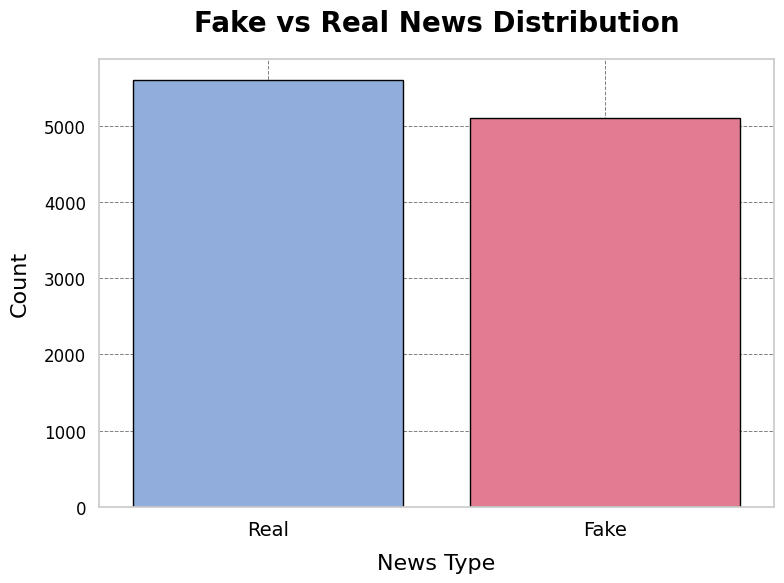

In [ ]:
plt.figure(figsize=(8, 6), facecolor=colors['background_color'])

sns.countplot(
    x='is_fake',
    data=df,
    palette=[colors['main_color'], colors['secondary_color']],
    saturation=0.85,
    edgecolor=colors['text_color']
)

plt.title('Fake vs Real News Distribution', fontsize=20, fontweight='bold', color=colors['title_color'], pad=20)
plt.xlabel('News Type', fontsize=16, color=colors['axis_color'], labelpad=10)
plt.ylabel('Count', fontsize=16, color=colors['axis_color'], labelpad=10)

plt.xticks(
    ticks=[0, 1],
    labels=['Real', 'Fake'],
    fontsize=14,
    color=colors['text_color']
)
plt.yticks(fontsize=12, color=colors['text_color'])

plt.grid(True, linestyle='--', linewidth=0.7, alpha=0.5, color=colors['grid_color'])

plt.tight_layout()
plt.show()


<ipython-input-60-4ed5dd51c933>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
<ipython-input-60-4ed5dd51c933>:8: UserWarning: 
The palette list has fewer values (5) than needed (10) and will cycle, which may produce an uninterpretable plot.
  sns.barplot(


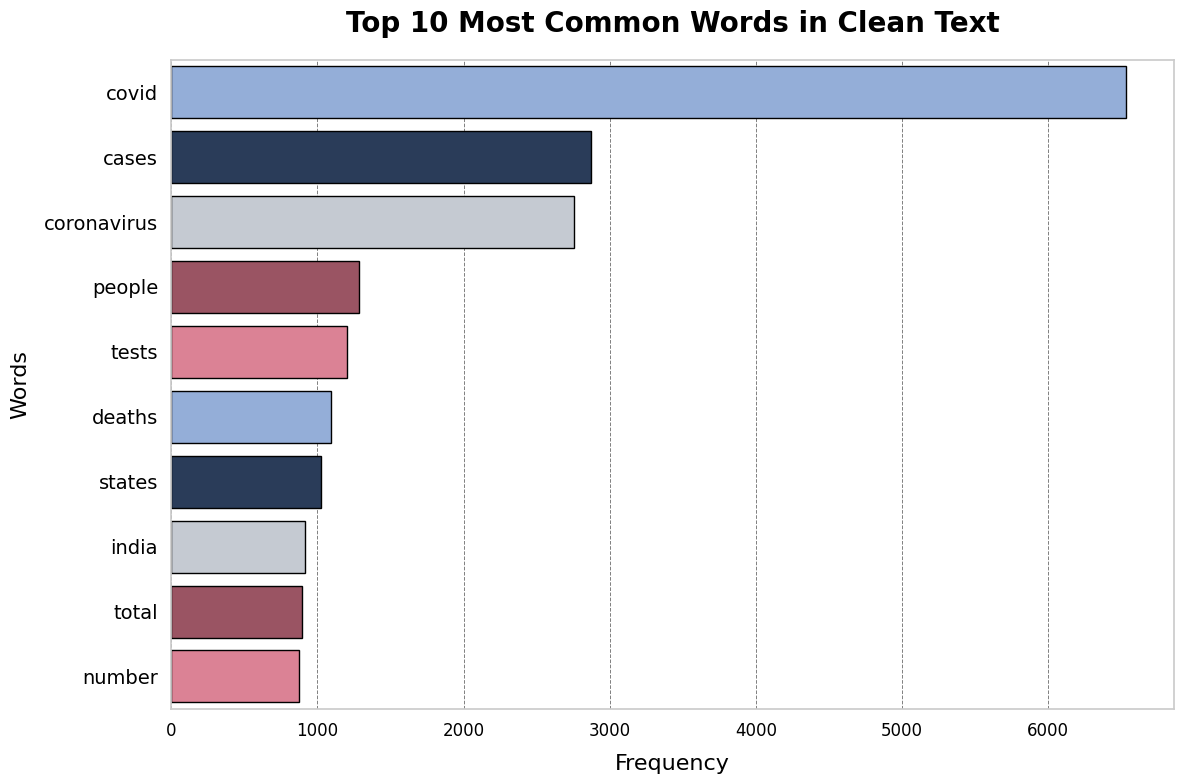

In [ ]:
all_words = ' '.join(df['clean_joined']).split()
word_counts = Counter(all_words)
top_words = word_counts.most_common(10)

words, counts = zip(*top_words)

plt.figure(figsize=(12, 8), facecolor=colors['background_color'])
sns.barplot(
    x=list(counts),
    y=list(words),
    palette=custom_palette,
    edgecolor=colors['text_color']
)

plt.title('Top 10 Most Common Words in Clean Text', fontsize=20, fontweight='bold', color=colors['title_color'], pad=20)
plt.xlabel('Frequency', fontsize=16, color=colors['axis_color'], labelpad=10)
plt.ylabel('Words', fontsize=16, color=colors['axis_color'], labelpad=10)

plt.xticks(fontsize=12, color=colors['text_color'])
plt.yticks(fontsize=14, color=colors['text_color'])

plt.grid(axis='x', linestyle='--', linewidth=0.7, alpha=0.5, color=colors['grid_color'])

plt.tight_layout()
plt.show()

**For fake news (wordcloud)**

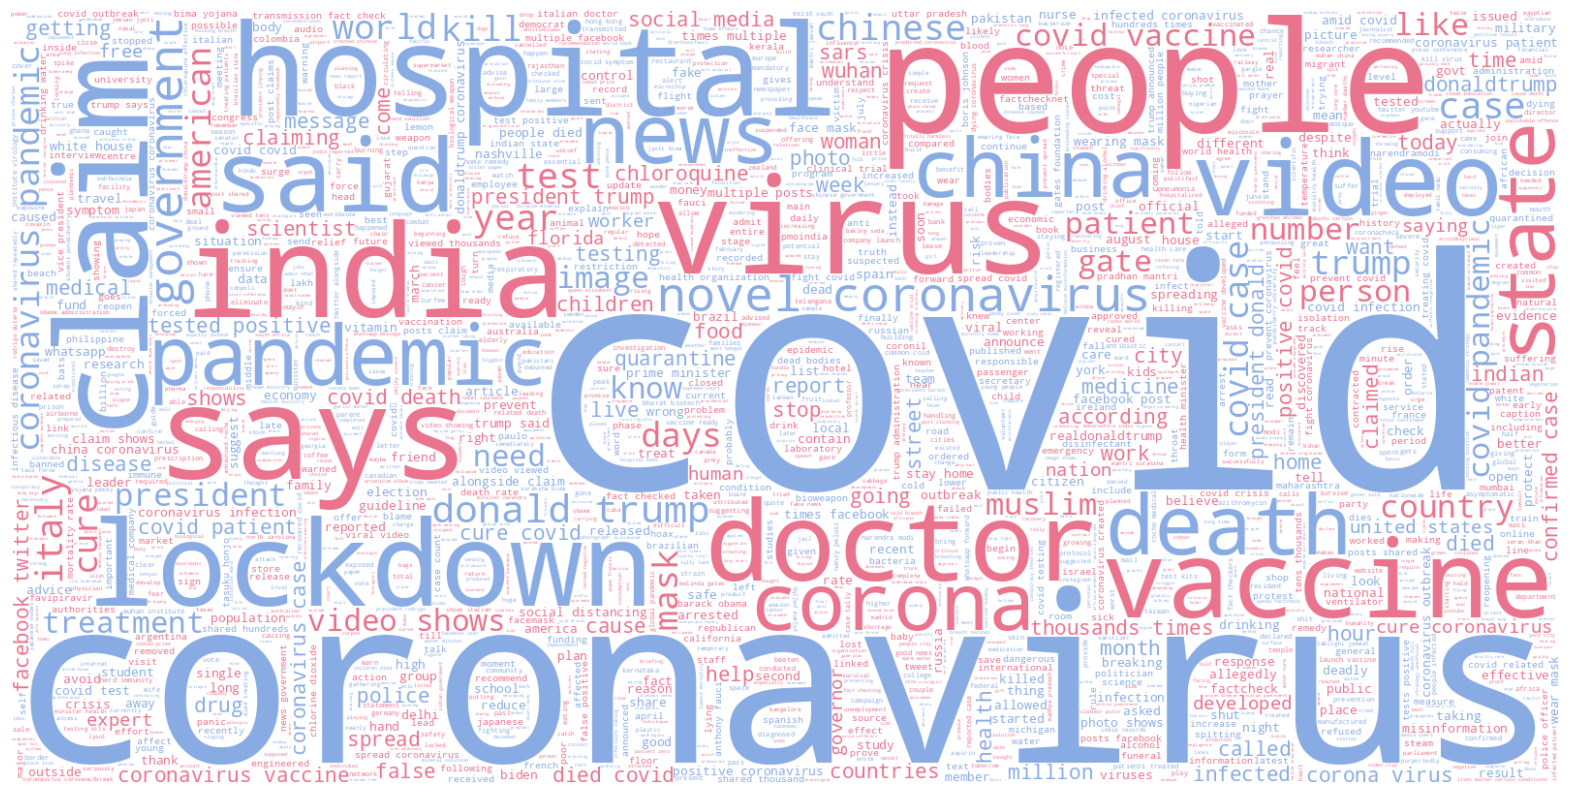

In [ ]:
def custom_color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    return random.choice(custom_palette_2)

plt.figure(figsize=(20, 20))

wc = WordCloud(
    max_words=2000,
    width=1600,
    height=800,
    stopwords=stop_words,
    color_func=custom_color_func,
    background_color= colors['background_color'],
    contour_color=colors['highlight_color'],
    contour_width=2
).generate(" ".join(df[df.is_fake == 1].clean_joined))

plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()

**For real news (wordcloud)**

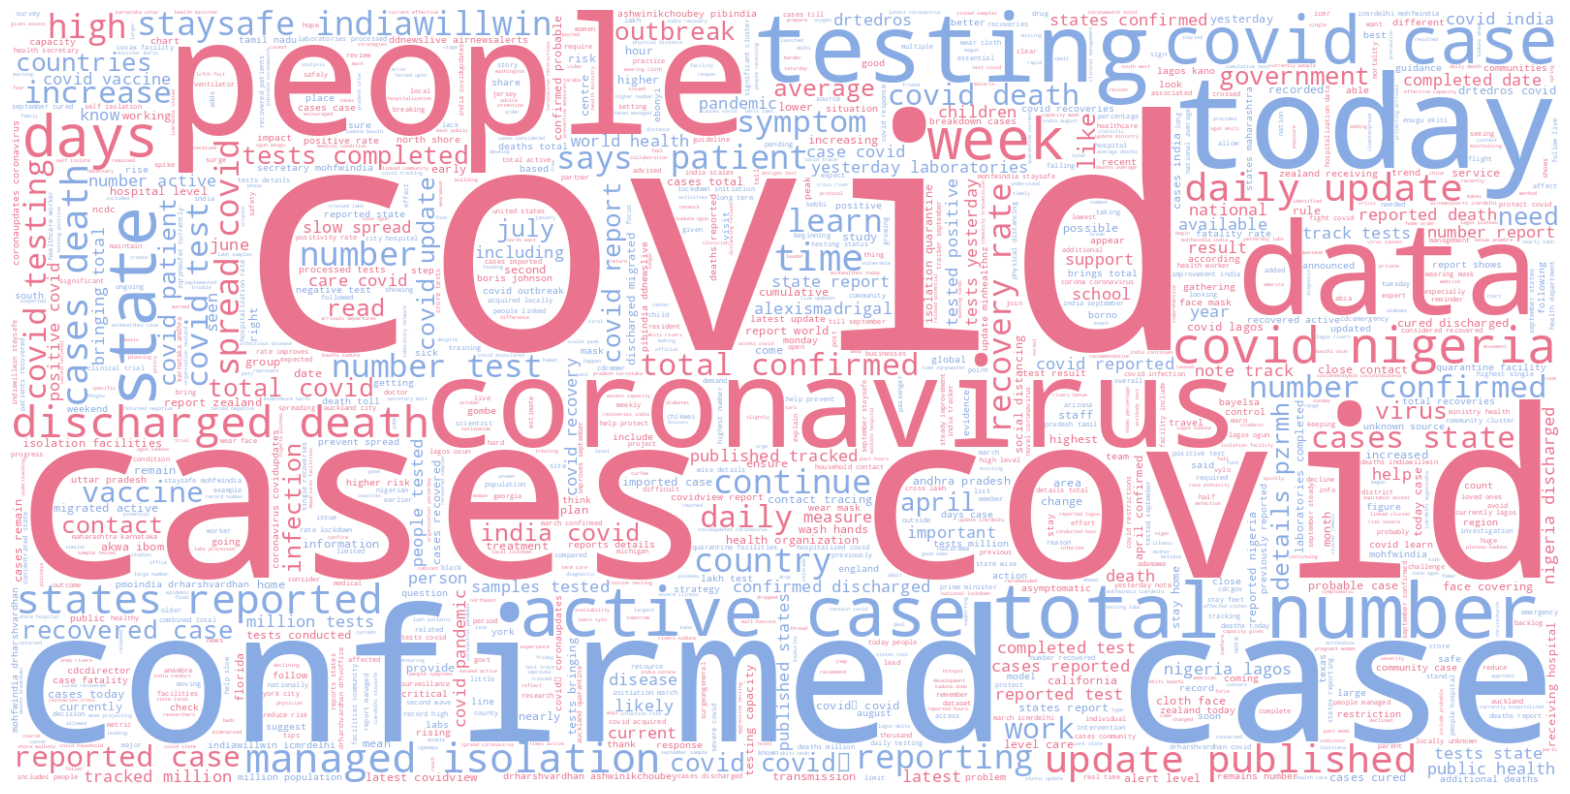

In [ ]:
def custom_color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    return random.choice(custom_palette_2)

plt.figure(figsize=(20, 20))

wc = WordCloud(
    max_words=2000,
    width=1600,
    height=800,
    stopwords=stop_words,
    color_func=custom_color_func,
    background_color= colors['background_color'],
    contour_color=colors['highlight_color'],
    contour_width=2
).generate(" ".join(df[df.is_fake == 0].clean_joined))

plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()

In [ ]:
maxlen = -1
for doc in df.clean_joined:
    tokens = nltk.word_tokenize(doc)
    if(maxlen<len(tokens)):
        maxlen = len(tokens)
print("The maximum number of words in any document is =", maxlen)

The maximum number of words in any document is = 766


Tweets > 100 words:  7


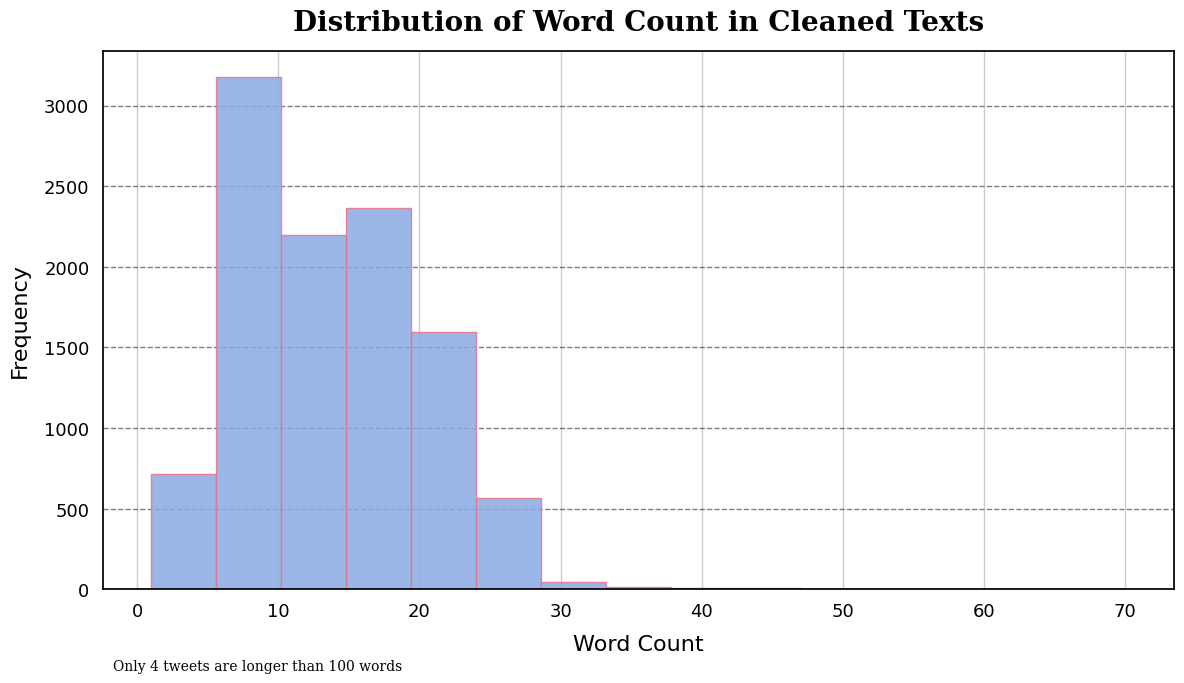

In [ ]:
word_counts = [len(nltk.word_tokenize(x)) for x in df.clean_joined]
filtered_word_counts = [count for count in word_counts if count <= 100]
long_tweets = [count for count in word_counts if count > 100]

print("Tweets > 100 words: ", len(long_tweets))

plt.figure(figsize=(12, 7), facecolor=colors['background_color'])
plt.hist(
    filtered_word_counts,
    bins=15,
    color=colors['main_color'],
    edgecolor=colors['secondary_color'],
    alpha=0.85
)

plt.title(
    'Distribution of Word Count in Cleaned Texts',
    fontsize=20,
    fontweight='bold',
    family='serif',
    color=colors['title_color'],
    pad=15
)

plt.xlabel('Word Count', fontsize=16, color=colors['axis_color'], labelpad=10)
plt.ylabel('Frequency', fontsize=16, color=colors['axis_color'], labelpad=10)

plt.xticks(fontsize=13, color=colors['text_color'])
plt.yticks(fontsize=13, color=colors['text_color'])

plt.grid(axis='y', linestyle='--', alpha=0.5, color=colors['grid_color'])

spine_color = colors['grid_color']
for spine in plt.gca().spines.values():
    spine.set_edgecolor(spine_color)

plt.gcf().set_facecolor(colors['background_color'])
plt.gca().set_facecolor(colors['background_color'])

plt.text(
    0.01, -0.15,
    "Only 4 tweets are longer than 100 words",
    fontsize=10,
    color=colors['text_color'],
    transform=plt.gca().transAxes,
    family='serif'
)

plt.tight_layout()
plt.show()

In [ ]:
word_counts = [len(nltk.word_tokenize(x)) for x in df.clean_joined]
filtered_word_counts = [count for count in word_counts if count > 100]
print("Tweets > 100: ", len(filtered_word_counts))

Tweets > 100:  7


**Only 4 tweets are longer than 100 characters**

In [ ]:
#df.to_csv('/content/drive/MyDrive/Data/News/Covid/news_prepared.csv', index=False)

# Data Preparation

In [ ]:
df.head(2)

,tweet,label,clean_joined,is_fake
0,The CDC currently reports 99031 deaths. In gen...,real,currently reports deaths general discrepancies...,0
1,States reported 1121 deaths a small rise from ...,real,states reported deaths small rise tuesday sout...,0


In [ ]:
list_of_words = []

for text in df.clean_joined:
    words = nltk.word_tokenize(text)
    list_of_words.extend(words)

unique_words = set(list_of_words)
total_words = list(unique_words)
print(f"Number of unique words: {len(total_words)}")

Number of unique words: 20796


In [ ]:
fake_words = []
real_words = []

for text in df[df['is_fake'] == 1].clean_joined:
    words = nltk.word_tokenize(text)
    fake_words.extend(words)

for text in df[df['is_fake'] == 0].clean_joined:
    words = nltk.word_tokenize(text)
    real_words.extend(words)

unique_fake_words = set(fake_words)
unique_real_words = set(real_words)

print(f"Number of unique words for is_fake = 1: {len(unique_fake_words)}")
print(f"Number of unique words for is_fake = 0: {len(unique_real_words)}")

Number of unique words for is_fake = 1: 12453
Number of unique words for is_fake = 0: 12165


In [ ]:
# Split data into train and test sets
x_train, x_test, y_train, y_test = train_test_split(df.clean_joined,
                                                     df.is_fake,
                                                     test_size=0.2,
                                                     random_state=42)
# Tokenize text data
tokenizer = Tokenizer(num_words=len(total_words))
tokenizer.fit_on_texts(x_train)

In [ ]:
train_sequences = tokenizer.texts_to_sequences(x_train)
test_sequences = tokenizer.texts_to_sequences(x_test)
total_words = len(tokenizer.word_index) + 1  # Adding 1 because indexing starts from 1

In [ ]:
# with open('/content/tokenizer.pkl', 'wb') as file:
#     pickle.dump(tokenizer, file)

In [ ]:
print("The encoding for document\n",df.clean_joined[0],"\n is : ",train_sequences[0])

The encoding for document
 currently reports deaths general discrepancies death counts different sources small explicable death toll stands roughly people today 
 is :  [456, 6839, 404, 3147, 515, 3, 6840, 1987, 891, 76, 1988, 6841, 86]


In [ ]:
# Pad sequences for uniform input size
maxlen = 25  # can be adjusted
padded_train = pad_sequences(train_sequences, maxlen=maxlen,
                             padding='post', truncating='post')
padded_test = pad_sequences(test_sequences, maxlen=maxlen, truncating='post')

In [ ]:
y_train = np.array(y_train)
y_test = np.array(y_test)

print(f"Shape of padded_train: {padded_train.shape}")
print(f"Shape of padded_test: {padded_test.shape}")
print(f"Shape of y_train: {y_train.shape}")

Shape of padded_train: (8560, 25)
Shape of padded_test: (2140, 25)
Shape of y_train: (8560,)


**Dataset Observations**
- The dataset was balanced between real and fake news posts, sourced from Twitter, Facebook, and Instagram.
- **Preprocessing techniques** such as lowercasing, punctuation removal, and stopword filtering significantly improved model performance.
- Word count distribution showed that **most tweets contained fewer than 100 words**, with only **7 exceeding 100 words**.

# Bidirectional LSTM

In [ ]:
model = Sequential()
model.add(Embedding(input_dim=total_words, output_dim=128))

# Bi-Directional LSTM layer
model.add(Bidirectional(LSTM(128)))
# a Dense layer with ReLU activation
model.add(Dense(128, activation='relu'))
# output layer with a sigmoid activation
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_2 (Bidirectional)      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.fit(padded_train, y_train,
          batch_size=64,
          validation_split=0.1,
          epochs=10)

Epoch 1/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.7667 - loss: 0.4561 - val_accuracy: 0.9182 - val_loss: 0.2187
Epoch 2/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9683 - loss: 0.0900 - val_accuracy: 0.9194 - val_loss: 0.2858
Epoch 3/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.9908 - loss: 0.0298 - val_accuracy: 0.8937 - val_loss: 0.4014
Epoch 4/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.9957 - loss: 0.0129 - val_accuracy: 0.9089 - val_loss: 0.3790
Epoch 5/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9957 - loss: 0.0138 - val_accuracy: 0.9042 - val_loss: 0.4122
Epoch 6/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9970 - loss: 0.0095 - val_accuracy: 0.9065 - val_loss: 0.5780
Epoch 7/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9993 - loss: 0.0020 - val_accuracy: 0.9124 - val_loss: 0.6111
Epoch 8/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 1.0000 - loss: 4.6504e-05 - val_

In [ ]:
#model.save('Сovid/lstm_model.h5')

**Assess the Model**

In [ ]:
predictions = model.predict(padded_test)
predictions = (predictions > 0.5).astype('int32')

67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


In [ ]:
accuracy = model.evaluate(padded_test, y_test)
print(f"Model Accuracy: {accuracy[1]*100:.2f}%")

67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7826 - loss: 1.9482
Model Accuracy: 78.27%


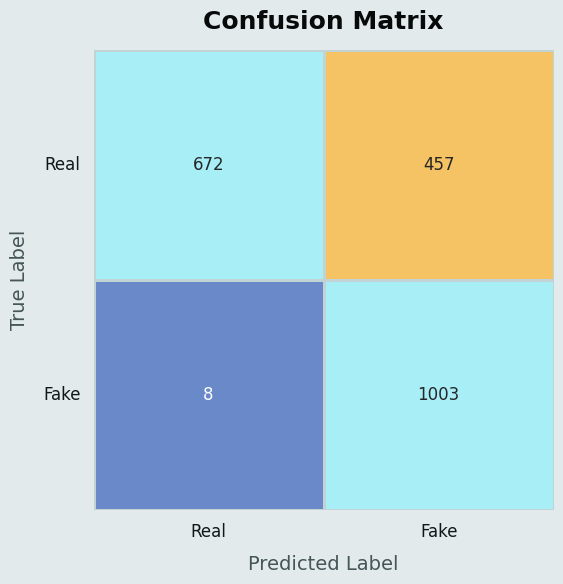

In [ ]:
cm = confusion_matrix(list(y_test), predictions)

plt.figure(figsize=(6, 6), facecolor=colors['background_color'])
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap=[colors['main_color'], colors['secondary_color'], colors['highlight_color']],
    cbar=False,
    linewidths=1,
    linecolor=colors['grid_color'],
    square=True
)

plt.title('Confusion Matrix', fontsize=18, fontweight='bold', color=colors['title_color'], pad=15)
plt.xlabel('Predicted Label', fontsize=14, color=colors['axis_color'], labelpad=10)
plt.ylabel('True Label', fontsize=14, color=colors['axis_color'], labelpad=10)

plt.xticks([0.5, 1.5], ['Real', 'Fake'], fontsize=12, color=colors['text_color'])
plt.yticks([0.5, 1.5], ['Real', 'Fake'], fontsize=12, color=colors['text_color'], rotation=0)

spine_color = colors['grid_color']
plt.gca().spines['top'].set_color(spine_color)
plt.gca().spines['right'].set_color(spine_color)
plt.gca().spines['left'].set_color(spine_color)
plt.gca().spines['bottom'].set_color(spine_color)

plt.gcf().set_facecolor(colors['background_color'])
plt.gca().set_facecolor(colors['background_color'])

plt.tight_layout()
plt.show()

## Bi-LSTM (Improved to fix Overfitting)

In [ ]:
# from tensorflow.keras.optimizers import Adam

In [ ]:
model = Sequential()
model.add(Embedding(input_dim=total_words, output_dim=128, embeddings_regularizer=regularizers.l2(1e-6)))

# Reduce LSTM size and increase dropout
model.add(Bidirectional(LSTM(4, dropout=0.6, recurrent_dropout=0.6)))

# Reduce dense layer size +  stronger regularization
model.add(Dense(16, activation='relu', kernel_regularizer=regularizers.l2(1e-1)))  # L2 Regularization
model.add(BatchNormalization())
model.add(Dropout(0.85))  # Increase dropout

# Output
model.add(Dense(1, activation='sigmoid'))

# slower learning rate
optimizer = Adam(learning_rate=5e-5, decay=1e-6)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=1, restore_best_weights=True)


/usr/local/lib/python3.11/dist-packages/keras/src/optimizers/base_optimizer.py:86: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


In [ ]:
history = model.fit(
    padded_train, y_train,
    batch_size=16,  # Smaller batch size --> improve generalization
    validation_split=0.2,
    epochs=20,
    callbacks=[early_stop]
)

Epoch 1/20
428/428 ━━━━━━━━━━━━━━━━━━━━ 71s 130ms/step - accuracy: 0.5172 - loss: 1.7991 - val_accuracy: 0.5286 - val_loss: 1.5368
Epoch 2/20
428/428 ━━━━━━━━━━━━━━━━━━━━ 50s 117ms/step - accuracy: 0.5026 - loss: 1.6398 - val_accuracy: 0.5304 - val_loss: 1.4527
Epoch 3/20
428/428 ━━━━━━━━━━━━━━━━━━━━ 52s 121ms/step - accuracy: 0.5147 - loss: 1.4939 - val_accuracy: 0.5426 - val_loss: 1.3746
Epoch 4/20
428/428 ━━━━━━━━━━━━━━━━━━━━ 83s 123ms/step - accuracy: 0.5295 - loss: 1.4140 - val_accuracy: 0.5602 - val_loss: 1.3054
Epoch 5/20
428/428 ━━━━━━━━━━━━━━━━━━━━ 48s 113ms/step - accuracy: 0.5330 - loss: 1.3196 - val_accuracy: 0.6063 - val_loss: 1.2375
Epoch 6/20
428/428 ━━━━━━━━━━━━━━━━━━━━ 53s 123ms/step - accuracy: 0.5234 - loss: 1.2473 - val_accuracy: 0.6320 - val_loss: 1.1740
Epoch 7/20
428/428 ━━━━━━━━━━━━━━━━━━━━ 81s 120ms/step - accuracy: 0.5695 - loss: 1.1714 - val_accuracy: 0.6887 - val_loss: 1.1025
Epoch 8/20
428/428 ━━━━━━━━━━━━━━━━━━━━ 83s 122ms/step - accuracy: 0.5931 - loss: 1

#### Find the Best Threshold

In [ ]:
probs = model.predict(padded_test)

# Find the best threshold based on accuracy
best_threshold = 0.5  # Default
best_accuracy = 0

for threshold in np.arange(0.3, 0.7, 0.01):  # thresholds between 0.3 and 0.7
    preds = (probs > threshold).astype('int32')
    acc = accuracy_score(y_test, preds)

    if acc > best_accuracy:
        best_accuracy = acc
        best_threshold = threshold

best_threshold, best_accuracy * 100

67/67 ━━━━━━━━━━━━━━━━━━━━ 11s 132ms/step


(0.6900000000000004, 64.85981308411215)

In [ ]:
final_predictions = (probs > best_threshold).astype('int32')
accuracy = accuracy_score(y_test, final_predictions)
print(f"Final Model Accuracy with Best Test Threshold: {accuracy * 100:.2f}%")

Final Model Accuracy with Best Test Threshold: 64.86%


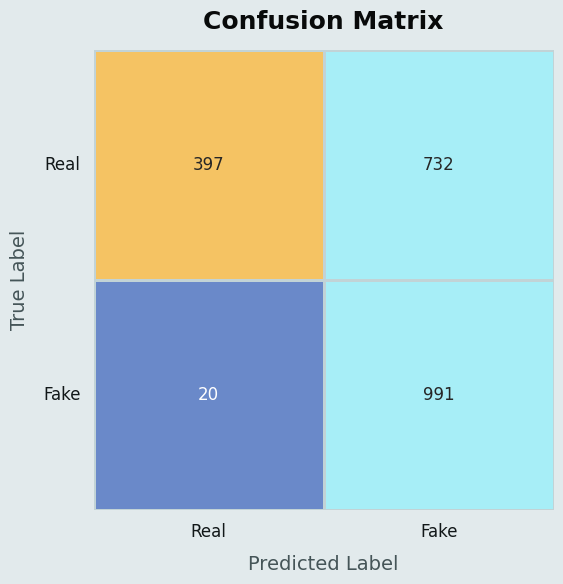

In [ ]:
cm = confusion_matrix(y_test, final_predictions)

plt.figure(figsize=(6, 6), facecolor=colors['background_color'])
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap=[colors['main_color'], colors['secondary_color'], colors['highlight_color']],
    cbar=False,
    linewidths=1,
    linecolor=colors['grid_color'],
    square=True
)

plt.title('Confusion Matrix', fontsize=18, fontweight='bold', color=colors['title_color'], pad=15)
plt.xlabel('Predicted Label', fontsize=14, color=colors['axis_color'], labelpad=10)
plt.ylabel('True Label', fontsize=14, color=colors['axis_color'], labelpad=10)

plt.xticks([0.5, 1.5], ['Real', 'Fake'], fontsize=12, color=colors['text_color'])
plt.yticks([0.5, 1.5], ['Real', 'Fake'], fontsize=12, color=colors['text_color'], rotation=0)

spine_color = colors['grid_color']
plt.gca().spines['top'].set_color(spine_color)
plt.gca().spines['right'].set_color(spine_color)
plt.gca().spines['left'].set_color(spine_color)
plt.gca().spines['bottom'].set_color(spine_color)

plt.gcf().set_facecolor(colors['background_color'])
plt.gca().set_facecolor(colors['background_color'])

plt.tight_layout()
plt.show()

# Support Vector Machine (SVM) with TF-IDF
Used as a baseline model to evaluate the rest of them

In [ ]:
vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = vectorizer.fit_transform(x_train)
X_test_tfidf = vectorizer.transform(x_test)

svm_model = SVC(kernel='linear', random_state=42)
svm_model.fit(X_train_tfidf, y_train)


test_preds_svm = svm_model.predict(X_test_tfidf)
accuracy_svm_test = accuracy_score(y_test, test_preds_svm)
print(f"Test Accuracy: {accuracy_svm_test * 100:.2f}%")

Test Accuracy: 92.76%


**Assess the Model**

Validation Accuracy: 92.76%


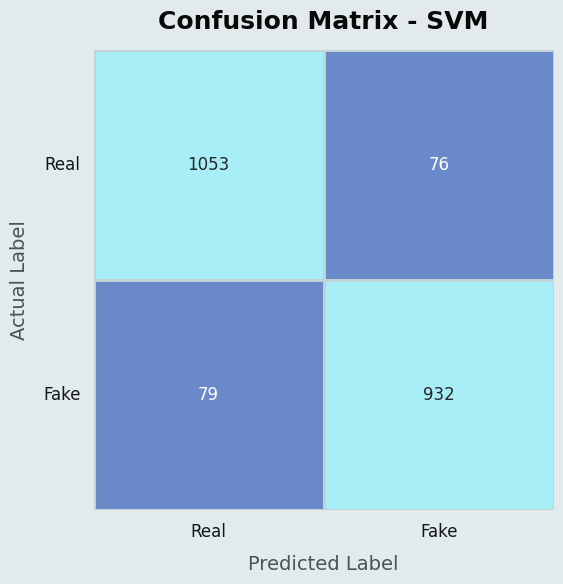

In [ ]:
accuracy_svm = accuracy_score(y_test, test_preds_svm)
print(f"Validation Accuracy: {accuracy_svm * 100:.2f}%")

cm_svm = confusion_matrix(y_test, test_preds_svm)

plt.figure(figsize=(6, 6), facecolor=colors['background_color'])
sns.heatmap(
    cm_svm,
    annot=True,
    fmt="d",
    cmap=[colors['main_color'], colors['secondary_color'], colors['highlight_color']],
    xticklabels=["Real", "Fake"],
    yticklabels=["Real", "Fake"],
    cbar=False,
    linewidths=1,
    linecolor=colors['grid_color'],
    square=True
)

plt.title(
    "Confusion Matrix - SVM",
    fontsize=18,
    fontweight='bold',
    color=colors['title_color'],
    pad=15
)
plt.xlabel("Predicted Label", fontsize=14, color=colors['axis_color'], labelpad=10)
plt.ylabel("Actual Label", fontsize=14, color=colors['axis_color'], labelpad=10)

plt.xticks([0.5, 1.5], ['Real', 'Fake'], fontsize=12, color=colors['text_color'])
plt.yticks([0.5, 1.5], ['Real', 'Fake'], fontsize=12, color=colors['text_color'], rotation=0)

plt.gcf().set_facecolor(colors['background_color'])
plt.gca().set_facecolor(colors['background_color'])
spine_color = colors['grid_color']
plt.gca().spines['top'].set_color(spine_color)
plt.gca().spines['right'].set_color(spine_color)
plt.gca().spines['left'].set_color(spine_color)
plt.gca().spines['bottom'].set_color(spine_color)

plt.tight_layout()
plt.show()

# DistilBERT

In [ ]:
train_df, val_df = train_test_split(df, test_size=0.2,
                                    stratify=df['is_fake'], random_state=42)

print(f"Training Set Size: {len(train_df)}")
print(f"Validation Set Size: {len(val_df)}")

Training Set Size: 8560
Validation Set Size: 2140


In [ ]:
class TextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer.encode_plus(
            text,
            max_length=self.max_length,
            truncation=True,
            padding="max_length",
            return_tensors="pt",
        )
        return {
            "input_ids": encoding["input_ids"].squeeze(0),
            "attention_mask": encoding["attention_mask"].squeeze(0),
            "label": torch.tensor(label, dtype=torch.long),
        }

In [ ]:
# load Tokenizer & prepare Dataset
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")

train_dataset = TextDataset(train_df["clean_joined"].tolist(), train_df["is_fake"].tolist(), tokenizer)
val_dataset = TextDataset(val_df["clean_joined"].tolist(), val_df["is_fake"].tolist(), tokenizer)

train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=16)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

In [ ]:
# DistilBERT Classifier
class DistilBertClassifier(nn.Module):
    def __init__(self, dropout=0.3):
        super(DistilBertClassifier, self).__init__()
        self.distilbert = DistilBertModel.from_pretrained("distilbert-base-uncased")
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(self.distilbert.config.hidden_size, 1)  # ✅ No Sigmoid

    def forward(self, input_ids, attention_mask):
        outputs = self.distilbert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.last_hidden_state[:, 0]  # ✅ CLS token
        dropout_output = self.dropout(pooled_output)
        return self.fc(dropout_output)  # ✅ No Sigmoid (Handled in Loss)


In [ ]:
from transformers import get_scheduler

In [ ]:
# Initialize Model
model = DistilBertClassifier()
model = model.cuda() if torch.cuda.is_available() else model

#  Loss, Optimizer & Scheduler
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
scheduler = get_scheduler("linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=len(train_dataloader) * 10)


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

In [ ]:
scaler = GradScaler(enabled=True)

epochs = 10
for epoch in range(epochs):
    print(f"Epoch {epoch + 1}/{epochs}")
    model.train()
    total_loss, total_correct, total_samples = 0, 0, 0

    for batch in train_dataloader:
        optimizer.zero_grad()

        with autocast(device_type="cuda"):
            outputs = model(batch["input_ids"].cuda(), batch["attention_mask"].cuda())
            loss = criterion(outputs, batch["label"].float().unsqueeze(1).cuda())

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        scheduler.step()

        total_loss += loss.item()
        predictions = (torch.sigmoid(outputs) > 0.5).float()
        total_correct += (predictions == batch["label"].unsqueeze(1).cuda()).sum().item()
        total_samples += batch["label"].size(0)

    accuracy = total_correct / total_samples
    print(f"Training Loss: {total_loss / len(train_dataloader):.4f}, Accuracy: {accuracy:.4f}")

# Validation
model.eval()
all_predictions, all_labels = [], []
with torch.no_grad():
    for batch in val_dataloader:
        outputs = model(batch["input_ids"].cuda(), batch["attention_mask"].cuda()).squeeze(1)
        predictions = (torch.sigmoid(outputs) > 0.5).float()
        all_predictions.extend(predictions.cpu().numpy())
        all_labels.extend(batch["label"].cpu().numpy())

Epoch 1/10
Training Loss: 0.2316, Accuracy: 0.9041
Epoch 2/10
Training Loss: 0.0932, Accuracy: 0.9676
Epoch 3/10
Training Loss: 0.0389, Accuracy: 0.9881
Epoch 4/10
Training Loss: 0.0190, Accuracy: 0.9944
Epoch 5/10
Training Loss: 0.0107, Accuracy: 0.9968
Epoch 6/10
Training Loss: 0.0042, Accuracy: 0.9988
Epoch 7/10
Training Loss: 0.0031, Accuracy: 0.9991
Epoch 8/10
Training Loss: 0.0015, Accuracy: 0.9996
Epoch 9/10
Training Loss: 0.0017, Accuracy: 0.9996
Epoch 10/10
Training Loss: 0.0012, Accuracy: 0.9998


**Assess the Model**

In [ ]:
# Evaluation
accuracy = accuracy_score(all_labels, all_predictions)
cm = confusion_matrix(all_labels, all_predictions)
print(f"Validation Accuracy: {accuracy * 100:.2f}%")

Validation Accuracy: 94.72%


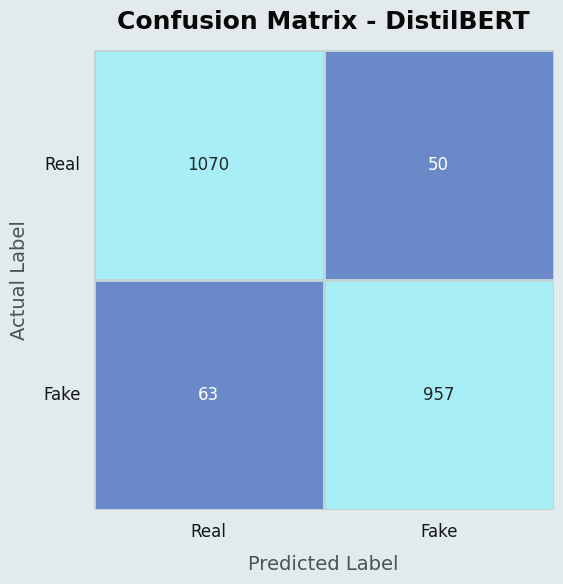

In [ ]:
plt.figure(figsize=(6, 6), facecolor=colors['background_color'])
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap=[colors['main_color'], colors['secondary_color'], colors['highlight_color']],  # Custom palette
    xticklabels=["Real", "Fake"],
    yticklabels=["Real", "Fake"],
    cbar=False,
    linewidths=1,
    linecolor=colors['grid_color'],
    square=True
)

plt.title(
    "Confusion Matrix - DistilBERT",
    fontsize=18,
    fontweight='bold',
    color=colors['title_color'],
    pad=15
)
plt.xlabel("Predicted Label", fontsize=14, color=colors['axis_color'], labelpad=10)
plt.ylabel("Actual Label", fontsize=14, color=colors['axis_color'], labelpad=10)

plt.xticks([0.5, 1.5], ["Real", "Fake"], fontsize=12, color=colors['text_color'])
plt.yticks([0.5, 1.5], ["Real", "Fake"], fontsize=12, color=colors['text_color'], rotation=0)

plt.gcf().set_facecolor(colors['background_color'])
plt.gca().set_facecolor(colors['background_color'])

spine_color = colors['grid_color']
for spine in plt.gca().spines.values():
    spine.set_edgecolor(spine_color)

plt.tight_layout()
plt.show()

In [ ]:
torch.save(model.state_dict(), '/content/distil_bert_trained_model.pth')

# BERT

In [ ]:
train_df, val_df = train_test_split(df, test_size=0.2, stratify=df['is_fake'], random_state=42)

In [ ]:
# Dataset Prep
class TextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer.encode_plus(
            text,
            max_length=self.max_length,
            truncation=True,
            padding="max_length",
            return_tensors="pt",
        )
        return {
            "input_ids": encoding["input_ids"].squeeze(0),
            "attention_mask": encoding["attention_mask"].squeeze(0),
            "label": torch.tensor(label, dtype=torch.long),
        }

In [ ]:
# Using 'clean_joined' for text and 'is_fake' for labels
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

train_dataset = TextDataset(train_df["clean_joined"].tolist(), train_df["is_fake"].tolist(), tokenizer)
val_dataset = TextDataset(val_df["clean_joined"].tolist(), val_df["is_fake"].tolist(), tokenizer)

train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=8)

# BERT Model for Binary Classification
class BertClassifier(nn.Module):
    def __init__(self, dropout=0.3):
        super(BertClassifier, self).__init__()
        self.bert = BertModel.from_pretrained("bert-base-uncased")
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(self.bert.config.hidden_size, 1)  # Binary classification
        self.sigmoid = nn.Sigmoid()

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output
        dropout_output = self.dropout(pooled_output)
        fc_output = self.fc(dropout_output)
        return self.sigmoid(fc_output)

model = BertClassifier()
model = model.cuda() if torch.cuda.is_available() else model

criterion = nn.BCELoss()  # Binary Cross-Entropy Loss
optimizer = Adam(model.parameters(), lr=2e-5)

In [ ]:
# Training Loop
epochs = 10
for epoch in range(epochs):
    print(f"Epoch {epoch + 1}/{epochs}")
    model.train()
    total_loss, total_correct, total_samples = 0, 0, 0

    for batch in train_dataloader:
        input_ids = batch["input_ids"].cuda() if torch.cuda.is_available() else batch["input_ids"]
        attention_mask = batch["attention_mask"].cuda() if torch.cuda.is_available() else batch["attention_mask"]
        labels = batch["label"].float().cuda() if torch.cuda.is_available() else batch["label"].float()

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask).squeeze()
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        predictions = (outputs > 0.5).float()
        total_correct += (predictions == labels).sum().item()
        total_samples += labels.size(0)

    accuracy = total_correct / total_samples
    print(f"Training Loss: {total_loss / len(train_dataloader):.4f}, Accuracy: {accuracy:.4f}")

Epoch 1/10
Training Loss: 0.2460, Accuracy: 0.9032
Epoch 2/10
Training Loss: 0.0990, Accuracy: 0.9662
Epoch 3/10
Training Loss: 0.0499, Accuracy: 0.9854
Epoch 4/10
Training Loss: 0.0276, Accuracy: 0.9917
Epoch 5/10
Training Loss: 0.0207, Accuracy: 0.9939
Epoch 6/10
Training Loss: 0.0202, Accuracy: 0.9942
Epoch 7/10
Training Loss: 0.0113, Accuracy: 0.9972
Epoch 8/10
Training Loss: 0.0137, Accuracy: 0.9953
Epoch 9/10
Training Loss: 0.0122, Accuracy: 0.9963
Epoch 10/10
Training Loss: 0.0112, Accuracy: 0.9966


**Assess the Model**

In [ ]:
# Validation
model.eval()
all_predictions = []
all_labels = []

with torch.no_grad():
    for batch in val_dataloader:
        input_ids = batch["input_ids"].cuda() if torch.cuda.is_available() else batch["input_ids"]
        attention_mask = batch["attention_mask"].cuda() if torch.cuda.is_available() else batch["attention_mask"]
        labels = batch["label"].cuda() if torch.cuda.is_available() else batch["label"]

        outputs = model(input_ids, attention_mask).squeeze()
        predictions = (outputs > 0.5).float()
        all_predictions.extend(predictions.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Evaluation
accuracy = accuracy_score(all_labels, all_predictions)
cm = confusion_matrix(all_labels, all_predictions)
print(f"Validation Accuracy: {accuracy * 100:.2f}%")

Validation Accuracy: 95.23%


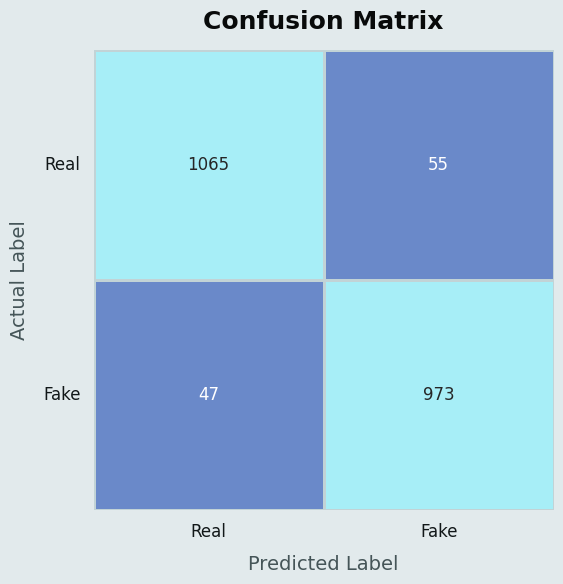

In [ ]:
plt.figure(figsize=(6, 6), facecolor=colors['background_color'])
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap=[colors['main_color'], colors['secondary_color'], colors['highlight_color']],
    xticklabels=["Real", "Fake"],
    yticklabels=["Real", "Fake"],
    cbar=False,
    linewidths=1,
    linecolor=colors['grid_color'],
    square=True
)

plt.title(
    "Confusion Matrix",
    fontsize=18,
    fontweight='bold',
    color=colors['title_color'],
    pad=15
)
plt.xlabel("Predicted Label", fontsize=14, color=colors['axis_color'], labelpad=10)
plt.ylabel("Actual Label", fontsize=14, color=colors['axis_color'], labelpad=10)

plt.xticks([0.5, 1.5], ["Real", "Fake"], fontsize=12, color=colors['text_color'])
plt.yticks([0.5, 1.5], ["Real", "Fake"], fontsize=12, color=colors['text_color'], rotation=0)

plt.gcf().set_facecolor(colors['background_color'])
plt.gca().set_facecolor(colors['background_color'])
spine_color = colors['grid_color']
for spine in plt.gca().spines.values():
    spine.set_edgecolor(spine_color)

plt.tight_layout()
plt.show()

In [ ]:
torch.save(model.state_dict(), '/content/bert_trained_model.pth')

# **Conclusions**

**Effectiveness of Models**
- **LSTM Model:** Achieved an accuracy of **78.27%**, indicating a good performance but showing potential overfitting, as seen in increasing validation loss.

- **Support Vector Machine (SVM):** The TF-IDF + SVM model provided a good baseline, its performance was better than the LSTM model.

- **DistilBERT:** Achieved **94.30% accuracy**, demonstrating its effectiveness in contextual understanding of text.
- **BERT:** Achieved the highest accuracy of **94.77%**, confirming its ability to capture deep semantic relationships in text data.


**Future Improvements**
- **Further fine-tuning of transformer models** (BERT and DistilBERT) with additional training epochs and hyperparameter tuning.
- **Incorporation of external knowledge sources** to improve real vs. fake classification (e.g., fact-checking APIs).
- **Explainability techniques** such as SHAP or LIME to understand model decisions and improve interpretability.
- **Deployment options** for real-time classification of misinformation on social media platforms.